In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 2.2 MB/s eta 0:00:0000:0100:01m


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# QSAR
«Наиболее фундаментальной и привлекательной задачей химии
является не столько создание новых молекул, сколько создание
свойств» Дж. Хэммонд.

Задачей QSAR/QSPR является поиск
связи между структурой химических объектов (соединений, реакций, смесей, материалов и др.) и их свойствами (химическими, физическими, физико-химическими, биологическими и др.). С точки зрения математики, речь идет о построении статистической модели F, которая связывает дескрипторы X химического объекта (числовые характеристики, определяемые структурой объекта) с его свойствами Y:
<center>
Y = F(X).
</center>

In [6]:
# Данные по противовирусной активности
data = pd.read_csv('/content/drive/MyDrive/chemtools/nii_influ_cc_ic_si.csv', delimiter=';')
data.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Picture-number
0,1007-Ya-213,2.7,500.0,185.2,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,1
1,1007-Ya-213,0.7,447.0,638.6,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2
2,1008-Ya-187,9.9,144.0,14.5,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,3
3,1009-As-106,8.3,500.0,60.2,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,4
4,1010-Ya-208,39.4,143.0,3.6,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,5


# Представление молекул
Наиболее распространеное линейное представление молекулы - SMILES (англ. Simplified Molecular Input Line Entry System – система упрощенного представления молекул в строке ввода).

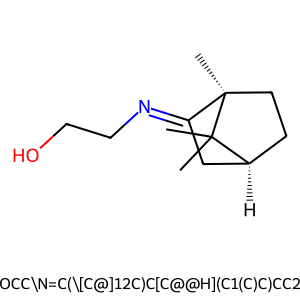

In [ ]:
mol = Chem.MolFromSmiles(data['SMILES'][0])
Draw.MolToImage(mol,legend=data['SMILES'][0])

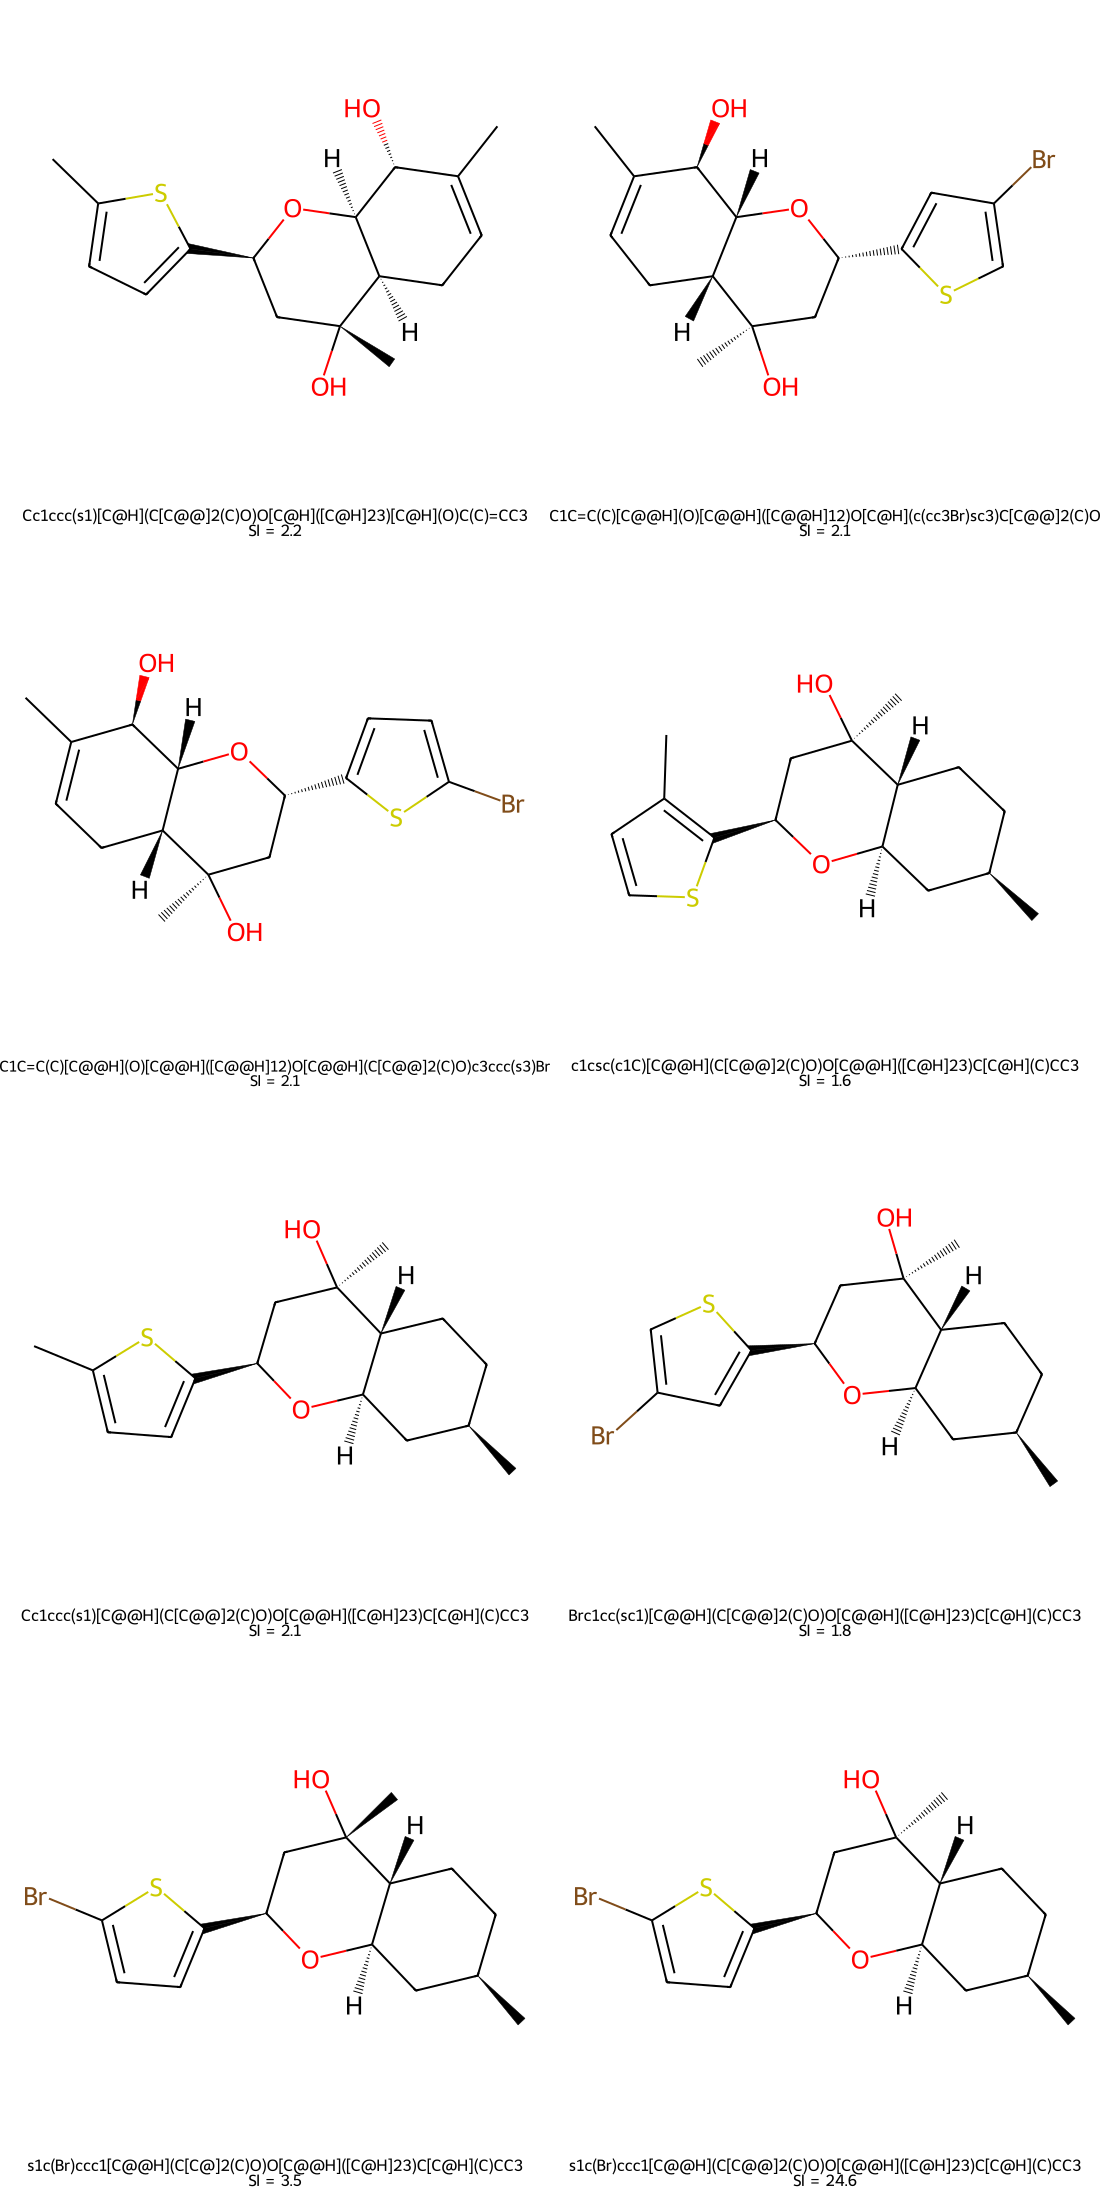

In [ ]:
# довольно примечательны последние две молекулы
lable = data['SMILES'][100:108].astype(str) + '\nSI = '+ data['SI'][100:108].astype(str)
mol_list = [Chem.MolFromSmiles(s) for s in data['SMILES'][100:108]]
Draw.MolsToGridImage(mol_list, molsPerRow=2, subImgSize=(550,550), legends=lable.to_list())

Важность учета стереоизомерии [Талидомид](https://ru.wikipedia.org/wiki/Талидомид)

# Дескрипторы
![image.jpg](https://images-na.ssl-images-amazon.com/images/P/3527318526.01.LZZZZZZZ.jpg)

В книге описывается более трех тысяч дескрипторов.

Рассмотрим некоторые из них


In [ ]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
X = descriptors_transformer.transform(data['SMILES'])
X.head()

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,14,1,2,2,1,2,2,80,0,0,2,195.306,2.2659,58.6168,32.59
1,14,1,2,2,1,2,2,80,0,0,2,195.306,2.2659,58.6168,32.59
2,18,0,2,2,0,2,5,104,0,0,2,250.430,3.6154,79.3190,15.60
3,16,0,2,2,0,2,3,92,0,0,2,222.376,2.8352,70.0850,15.60
4,17,0,3,3,0,3,3,98,0,0,2,239.359,2.3060,67.6630,29.54


In [4]:
def RDKfingerPrint(mol_smi, **kwargs):
    mol = Chem.MolFromSmiles(mol_smi)
    desc_vec = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(AllChem.RDKFingerprint(mol, **kwargs), desc_vec)
    return desc_vec

In [7]:
fp = RDKfingerPrint(data['SMILES'][0], maxPath=5)
fp, fp.shape

(array([0, 0, 0, ..., 0, 0, 1]), (2048,))

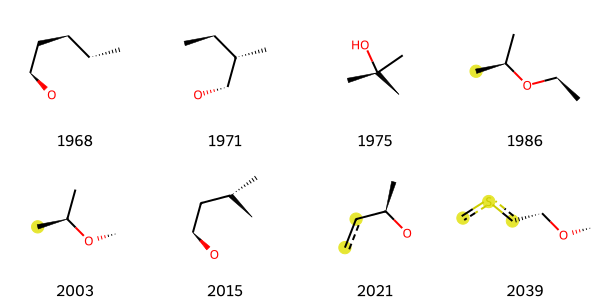

In [ ]:
bit_info = {}
mol = Chem.MolFromSmiles(data['SMILES'][106])
fp1 = RDKfingerPrint(data['SMILES'][106], maxPath=5,bitInfo=bit_info)

tpls = [(mol, x, bit_info) for x in bit_info]
Draw.DrawRDKitBits(tpls[-8:], molsPerRow=4, legends=[str(x) for x in bit_info][-8:])

In [ ]:
fp2 = RDKfingerPrint(data['SMILES'][107], maxPath=5)
# коэффициент подобия Танимото
T_sim = np.bitwise_and(fp1.astype(bool), fp2.astype(bool)).sum() / np.bitwise_or(fp1.astype(bool), fp2.astype(bool)).sum()
T_sim

1.0

* [CGRtools](https://github.com/cimm-kzn/CGRtools)
* [CIMtools ISIDA Fragmentor](https://github.com/cimm-kzn/CIMtools)
* [Список дескрипторов в библиотеке RDKit](http://www.rdkit.org/docs/GettingStartedInPython.html#List%20of%20Available%20Descriptors)
* [mol2vec](https://github.com/samoturk/mol2vec/tree/master)
* [обзор GNN для химии](https://www.nature.com/articles/s43246-022-00315-6)
* [создание fingerprint с помощью NNs](https://github.com/HIPS/neural-fingerprint/tree/master)